# XCDAT Demo: open dataset, subset, and land-sea mask

In this document, CMIP model output is loaded by using [xcdat](https://xcdat.readthedocs.io/en/latest/). 

Demo data used in this document is the time-series of surface temperature (ts) simulated by ACCESS1-0 model's historical simulation for [CMIP5](https://pcmdi.llnl.gov/mips/cmip5/), and the model's land fraction. Those data can be found from [ESGF](https://esgf-node.llnl.gov), and also included as a part of PCMDI Metrics Pacakage ([PMP](https://github.com/PCMDI/pcmdi_metrics))'s demo data that can be downloaded following this [PMP demo](https://github.com/PCMDI/pcmdi_metrics/blob/master/doc/jupyter/Demo/Demo_0_download_data.ipynb).

To run this notebook, you will need [juyter lab notebook](https://jupyter.org/), xcdat and cartropy (optional) installed in your environment.

Author: Jiwoo Lee (2021. 10)

In [1]:
import os

In [2]:
demo_data_dir = 'demo_data/CMIP5_demo_data'
demo_filename = 'ts_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc'
demo_file = os.path.join(demo_data_dir, demo_filename)

## 1. Open dataset using xcdat

### 1.1 Load dataset into memory

In [3]:
import xcdat

In [4]:
ds = xcdat.open_dataset(demo_file)

In [5]:
ts = ds.ts

In [6]:
ts

<xarray.DataArray 'ts' (time: 1872, lat: 145, lon: 192)>
[52116480 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2005-12-16T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:     surface_temperature
    long_name:         Surface Temperature
    comment:           ""skin"" temperature (i.e., SST for open ocean)
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2012-01-17T03:16:09Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

### 1.2 Data quick check

#### Check dimensions

In [7]:
ts.shape

(1872, 145, 192)

#### Field quick view -- plot data on the first time step

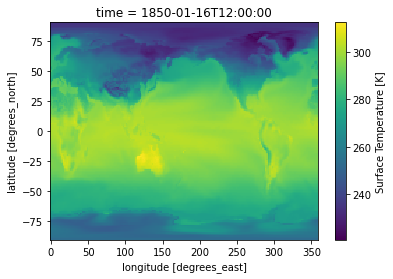

In [8]:
ts.isel(time=0).plot()

# Or, below commends do the same:

# ts[0].plot()
# ts.isel(time=slice(0, 1)).plot()
# ts.sel(time=ds.ts.time[0]).plot()

#### Check date of first time step 

In [9]:
ts.time[0].values

numpy.datetime64('1850-01-16T12:00:00.000000000')

#### Check date of last time step 

In [10]:
ts.time[-1].values

numpy.datetime64('2005-12-16T12:00:00.000000000')

### 1.3 Subset

#### Original dimensions

In [11]:
ts.shape

(1872, 145, 192)

#### Temporal subset

In [12]:
ts1 = ds.ts.sel(time=slice('1850-01-01', '1850-12-31'))
ts1.shape

(12, 145, 192)

#### Spatial subset

In [13]:
ts2 = ds.ts.sel(lat=slice(20, 50), lon=slice(220, 320))
ts2.shape

(1872, 25, 53)

#### Spatio-tempoal subset

In [14]:
ts3 = ds.ts.sel(time=slice('1850-01-01 00:00:00', '1850-12-31 23:59:59'), lat=slice(20, 50), lon=slice(220, 320))
ts3.shape

(12, 25, 53)

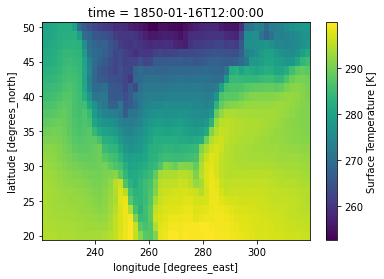

In [15]:
ts3[0].plot()

You can also visualize data on a map using [cartropy](https://scitools.org.uk/cartopy/docs/latest/) as below. Useage example also can be found [here](http://xarray.pydata.org/en/stable/user-guide/plotting.html).

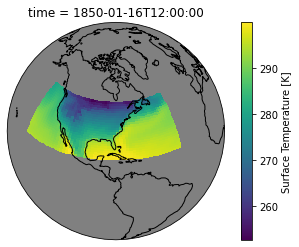

In [16]:
import cartopy.crs as ccrs

p = ts3.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()

PMP uses [predefined domains](https://github.com/PCMDI/pcmdi_metrics/blob/master/share/default_regions.py). Below capability was made to mimic that capability.

In [17]:
def region_subset(d, regions_specs, region=None):
    
    if ((region == None) or 
        (region != None) and (region not in list(regions_specs.keys()))):
        print('Error: region not defined')
    else:    
        if 'domain' in list(regions_specs[region].keys()):
            if 'latitude' in list(regions_specs[region]['domain'].keys()):
                lat0 = regions_specs[region]['domain']['latitude'][0]
                lat1 = regions_specs[region]['domain']['latitude'][1]
                if 'latitude' in (d.coords.dims):
                    d = d.sel(latitude=slice(lat0, lat1))
                elif 'lat' in (d.coords.dims):
                    d = d.sel(lat=slice(lat0, lat1))

            if 'longitude' in list(regions_specs[region]['domain'].keys()):
                lon0 = regions_specs[region]['domain']['longitude'][0]
                lon1 = regions_specs[region]['domain']['longitude'][1]
                if 'longitude' in (d.coords.dims):
                    d = d.sel(longitude=slice(lon0, lon1))
                elif 'lon' in (d.coords.dims):
                    d = d.sel(lon=slice(lon0, lon1))

    return d

In [18]:
regions_specs = {
    'NHEX': {'domain': {'latitude': (30., 90)}},
    'SHEX': {'domain': {'latitude': (-90., 30)}},
    'TROPICS': {'domain': {'latitude': (-30., 30)}},
    'global': {},
    }

In [19]:
ts4 = region_subset(ts.sel(time=slice('1850-01-01 00:00:00', '1850-12-31 23:59:59')), regions_specs, 'NHEX')
ts4.shape

(12, 49, 192)

In [20]:
ts4 = region_subset(ts.sel(time=slice('1850-01-01 00:00:00', '1850-12-31 23:59:59')), regions_specs, 'TROPICS')
ts4.shape

(12, 49, 192)

In [21]:
ts4 = region_subset(ts.sel(time=slice('1850-01-01 00:00:00', '1850-12-31 23:59:59')), regions_specs, 'global')
ts4.shape

(12, 145, 192)

## 2. Annual Cycle

In [22]:
ts_ann = ts.groupby('time.month').mean('time')

In [23]:
ts_ann.shape

(12, 145, 192)

## 3. Seasonal Mean

In [24]:
ts_seasons = ts.groupby('time.season').mean('time')

In [25]:
ts_seasons.shape

(4, 145, 192)

## 4. Land-sea mask

- Open land fraction of the given model grid and apply land or sea mask to the field of interest, using [`xarray.DataArray.where`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html) capbility.
- Relvant example usage also can be found [here](https://geohackweek.github.io/nDarrays/09-masking/).

In [26]:
demo_lsmsk_filename = 'sftlf_fx_ACCESS1-0_amip_r0i0p0.nc'
demo_lsmsk_file = os.path.join(demo_data_dir, demo_lsmsk_filename)

In [27]:
ds_lsmsk = xcdat.open_dataset(demo_lsmsk_file)
ds_lsmsk

<xarray.Dataset>
Dimensions:   (lat: 145, bnds: 2, lon: 192)
Coordinates:
  * lat       (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon       (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 ...
    lon_bnds  (lon, bnds) float64 ...
    sftlf     (lat, lon) float32 ...
Attributes: (12/29)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          amip
    source:                 ACCESS1-0 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1-0
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    title:                  ACCESS1-0 model output prepared for CMIP5 AMIP
    parent_experiment:      N/A
    modeling_realm:         atmos
    realization:            0
    cmor_version:           2.8.0
    xcdat_infer:            sftlf

In [28]:
sftlf = ds_lsmsk.sftlf

### 4.1 Land

In [29]:
ts_land = ts.where(sftlf!=0.)

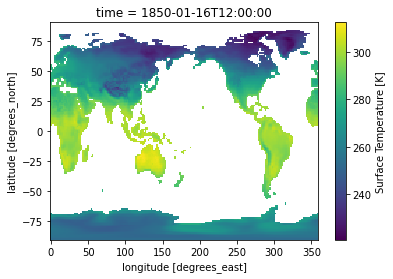

In [30]:
ts_land.isel(time=0).plot()

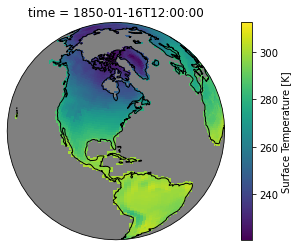

In [31]:
p = ts_land.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()

### 4.2 Ocean

In [32]:
ts_sea = ts.where(sftlf==0.)

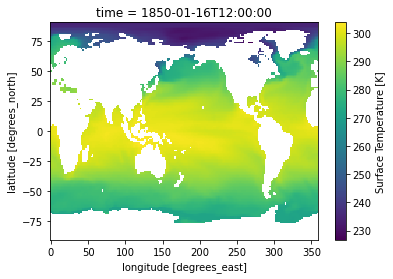

In [33]:
ts_sea.isel(time=0).plot()

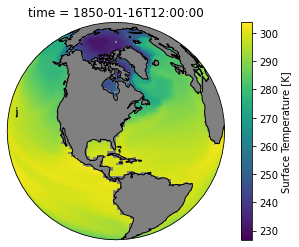

In [34]:
p = ts_sea.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()